In [2]:
# importing the necessary libraries
import os
import requests
import pandas as pd
import numpy as np
import pickle
import json

In [4]:
# read the city bikes csv file
df_city_bikes = pd.read_csv('df_city_bikes.csv')

In [5]:
df_city_bikes.head()

,Unnamed: 0,Station Name,Latitude,Longitude,Available Bikes
0,0,Chilco & Barclay,49.291909,-123.140713,12
1,1,St George & Broadway,49.262321,-123.093060,2
2,2,Britannia Parking Lot,49.275882,-123.071865,2
3,3,Morton & Denman,49.288030,-123.142135,9
4,4,Thornton & National,49.273777,-123.092723,2


In [6]:
# get the api keys as environmenet variables

fsq_api_key = os.environ['FOURSQUARE_API_KEY']
yelp_api_key = os.environ['YELP_API_KEY']


# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [7]:
# check teh length of stations
N_stations = len(df_city_bikes)

In [8]:
N_stations

258

In [49]:
# define the parameters and url to send request
radius = 500 # 300m radius is selected due to how the odel will be defined as we will be looking at the number of pois in an area
limit = 50
categories = '13065,16032'

url_foursquare = "https://api.foursquare.com/v3/places/search"

headers = {
    "accept": "application/json",
    "Authorization": fsq_api_key
}

In [82]:
# loop through each row
df_results_all = []

for idx in range(N_stations):

    lat = df_city_bikes['Latitude'].iloc[idx]
    lng = df_city_bikes['Longitude'].iloc[idx]
    ll = f"{lat},{lng}"

    params = {
        'radius': radius,
        'categories': categories,
        'll': ll,
        'limit': limit
    }


    response_fsq = requests.get(url_foursquare, headers=headers, params=params)

    results_fsq = response_fsq.json()
    
    #parse the json file and convert to a dataframe
    df_results = pd.json_normalize(results_fsq['results'])
    # create a new column to show the bike station index
    df_results['bike_station_index'] = idx
    # append dataframe results to empty list
    df_results_all.append(df_results)


print(response_fsq.status_code)
    

200


In [83]:
# create union using concat to get for all stations
df_results_all = pd.concat(df_results_all)

In [84]:
df_results_all.head()

,fsq_id,categories,chains,closed_bucket,distance,link,name,timezone,geocodes.drop_off.latitude,geocodes.drop_off.longitude,...,location.region,related_places.parent.fsq_id,related_places.parent.categories,related_places.parent.name,location.address_extended,bike_station_index,related_places.children,geocodes.front_door.latitude,geocodes.front_door.longitude,location.po_box
0,4aa7455df964a5208e4c20e3,"[{'id': 13276, 'name': 'Sushi Restaurant', 'sh...",[],VeryLikelyOpen,308,/v3/places/4aa7455df964a5208e4c20e3,Kingyo Izakaya 金魚居酒屋,America/Vancouver,49.290524,-123.136877,...,BC,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,4cd8423915d8b60c611f650e,"[{'id': 13236, 'name': 'Italian Restaurant', '...",[],LikelyOpen,354,/v3/places/4cd8423915d8b60c611f650e,Tavola,America/Vancouver,49.291726,-123.135836,...,BC,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2,5851f5b5297c16529dd5cf93,"[{'id': 13073, 'name': 'Australian Restaurant'...",[],VeryLikelyOpen,299,/v3/places/5851f5b5297c16529dd5cf93,Peaked Pies,America/Vancouver,49.289508,-123.138405,...,BC,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
3,4aa75933f964a520bf4c20e3,"[{'id': 13299, 'name': 'Malay Restaurant', 'sh...",[],LikelyOpen,400,/v3/places/4aa75933f964a520bf4c20e3,Banana Leaf,America/Vancouver,NaN,NaN,...,BC,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4,4abfcaf5f964a5203c9220e3,"[{'id': 13099, 'name': 'Chinese Restaurant', '...",[],LikelyOpen,385,/v3/places/4abfcaf5f964a5203c9220e3,Legendary Noodle House,America/Vancouver,NaN,NaN,...,BC,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [85]:
# define a for loop to extract category from categories table
restaurants = []
parks = []

for cat in df_results_all['categories']:
    if cat[0]['id'] == 16032:
        parks.append(1)
        restaurants.append(0)
    else:
        parks.append(0)
        restaurants.append(1)
df_results_all.loc[:,'restaurants'] = restaurants
df_results_all.loc[:, 'parks'] = parks
    
    

In [86]:
df_results_all

,fsq_id,categories,chains,closed_bucket,distance,link,name,timezone,geocodes.drop_off.latitude,geocodes.drop_off.longitude,...,related_places.parent.categories,related_places.parent.name,location.address_extended,bike_station_index,related_places.children,geocodes.front_door.latitude,geocodes.front_door.longitude,location.po_box,restaurants,parks
0,4aa7455df964a5208e4c20e3,"[{'id': 13276, 'name': 'Sushi Restaurant', 'sh...",[],VeryLikelyOpen,308,/v3/places/4aa7455df964a5208e4c20e3,Kingyo Izakaya 金魚居酒屋,America/Vancouver,49.290524,-123.136877,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
1,4cd8423915d8b60c611f650e,"[{'id': 13236, 'name': 'Italian Restaurant', '...",[],LikelyOpen,354,/v3/places/4cd8423915d8b60c611f650e,Tavola,America/Vancouver,49.291726,-123.135836,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
2,5851f5b5297c16529dd5cf93,"[{'id': 13073, 'name': 'Australian Restaurant'...",[],VeryLikelyOpen,299,/v3/places/5851f5b5297c16529dd5cf93,Peaked Pies,America/Vancouver,49.289508,-123.138405,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
3,4aa75933f964a520bf4c20e3,"[{'id': 13299, 'name': 'Malay Restaurant', 'sh...",[],LikelyOpen,400,/v3/places/4aa75933f964a520bf4c20e3,Banana Leaf,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
4,4abfcaf5f964a5203c9220e3,"[{'id': 13099, 'name': 'Chinese Restaurant', '...",[],LikelyOpen,385,/v3/places/4abfcaf5f964a5203c9220e3,Legendary Noodle House,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,5f2d918d3731e5073cb1d691,"[{'id': 13002, 'name': 'Bakery', 'short_name':...",[],VeryLikelyOpen,425,/v3/places/5f2d918d3731e5073cb1d691,Melo Patisserie,America/Vancouver,49.263710,-123.101546,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
46,4c14598fa5eb76b03cb5c1b7,"[{'id': 13027, 'name': 'Bistro', 'short_name':...",[],LikelyOpen,428,/v3/places/4c14598fa5eb76b03cb5c1b7,Jamies Bistro Restaurant,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
47,5c6fc0c3446ea60037c21fd9,"[{'id': 13040, 'name': 'Dessert Shop', 'short_...",[],LikelyOpen,429,/v3/places/5c6fc0c3446ea60037c21fd9,Billy Button Dessert Bar,America/Vancouver,49.262922,-123.101476,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
48,4ace7f72f964a520e6d020e3,"[{'id': 13049, 'name': 'Diner', 'short_name': ...",[],LikelyOpen,440,/v3/places/4ace7f72f964a520e6d020e3,Josephine's Restaurant Inc,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0


In [94]:
# check unique values in parks and restaurants
df_results_all['parks'].value_counts()


parks
0    9928
1     524
Name: count, dtype: int64

In [95]:
df_results_all['restaurants'].value_counts()

restaurants
1    9928
0     524
Name: count, dtype: int64

In [65]:
# select columns to be used for analysis
df_results_all = df_results_all[['bike_station_index', 'distance', 'restaurants', 'parks']]

In [66]:
df_results_all

,bike_station_index,distance,restaurants,parks
0,0,308,1,0
1,0,354,1,0
2,0,299,1,0
3,0,400,1,0
4,0,385,1,0
...,...,...,...,...
45,257,425,1,0
46,257,428,1,0
47,257,429,1,0
48,257,440,1,0


In [67]:
# save file to csv
df_results_all.to_csv('fsq_data.csv')

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [ ]:
radius = 1000
limit = 20
categories = "restaurants,cafes,bars,parks"

url_yelp = "https://api.yelp.com/v3/businesses/search"

headers_yelp = {
    "accept": "application/json",
    "authorization": "Bearer " + yelp_api_key
}


In [ ]:
df_results_all_yelp = []

for i in range(N_stations):

    latitude = df_city_bikes['latitude'].iloc[idx]
    longitude = df_city_bikes['longitude'].iloc[idx]
    # ll = f"{lat},{lng}"

    params_yelp = {
        'radius': radius,
        'categories': categories,
        'latitude': latitude,
        'longitude': longitude,
        'limit': limit
    }


    response_yelp = requests.get(url_yelp, headers=headers_yelp, params=params_yelp)

    results_yelp = response_yelp.json()

    

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [269]:
# view the keys in the result
results_yelp.keys()

dict_keys(['businesses', 'total', 'region'])

In [177]:
results_yelp['total']

247

Put your parsed results into a DataFrame

In [271]:
# convert to dataframe
df_results_yelp = pd.json_normalize(results_yelp['businesses'])
df_results_yelp['bike_station_index'] = idx
# append this to the empty list
df_results_all_yelp.append(df_results_yelp)

In [ ]:
df_results_yelp.head()

In [275]:
# concat the results
df_results_all_yelp = pd.concat(df_results_all_yelp)

In [ ]:
df_results_all_yelp.reset_index()

In [ ]:
df_results_all_yelp

In [ ]:
df_results_all_yelp.shape

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

* The foursquare API gives me a more complete data. The yelp data provides less data coverage. Foursquare covers more than businesses eg train staions and daycares while is mostly business.
* Though the yelp API provides information on customer reviews, for the scope of this project I will be focusing of fsq_id (number of POIs in a location) and distance to build the model.

Get the top 10 restaurants according to their rating

In [293]:
df_results_all_yelp.groupby('name')['rating'].max().sort_values(ascending=False)

name
Petite Bao                      4.7
Casereccio Foods                4.7
Chewie's Chicken & Biscuits     4.6
Folke Restaurant                4.6
Healthy Noodle House            4.5
Delara                          4.3
Purebread                       4.3
Fable Kitchen                   4.3
Raisu                           4.2
Hanoi Old Quarter Restaurant    4.2
Tera V Burger                   4.1
Little Bird Dim Sum             4.0
Neverland Tea Salon             4.0
Dark Table                      4.0
Pho Japolo                      3.9
East Is East                    3.9
Au Comptoir                     3.9
Mr. Red Cafe                    3.8
Nat's New York Pizzeria         3.7
Banana Leaf                     3.6
Name: rating, dtype: float64

# Data Exploration and Wrangling

In [ ]:
# read the fsq csv file
#fsq_results = pd.read_csv('fsq_data.csv')

In [74]:
# import the city_bikes data as we will be using this for analysis as well
city_bikes_data = pd.read_csv('df_city_bikes.csv')

In [ ]:
# view teh columns for the fsq data
df_results_all.head()

,fsq_id,categories,chains,closed_bucket,distance,link,name,timezone,geocodes.drop_off.latitude,geocodes.drop_off.longitude,...,related_places.parent.categories,related_places.parent.name,location.address_extended,bike_station_index,related_places.children,geocodes.front_door.latitude,geocodes.front_door.longitude,location.po_box,restaurants,parks
0,4aa7455df964a5208e4c20e3,"[{'id': 13276, 'name': 'Sushi Restaurant', 'sh...",[],VeryLikelyOpen,308,/v3/places/4aa7455df964a5208e4c20e3,Kingyo Izakaya 金魚居酒屋,America/Vancouver,49.290524,-123.136877,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
1,4cd8423915d8b60c611f650e,"[{'id': 13236, 'name': 'Italian Restaurant', '...",[],LikelyOpen,354,/v3/places/4cd8423915d8b60c611f650e,Tavola,America/Vancouver,49.291726,-123.135836,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
2,5851f5b5297c16529dd5cf93,"[{'id': 13073, 'name': 'Australian Restaurant'...",[],VeryLikelyOpen,299,/v3/places/5851f5b5297c16529dd5cf93,Peaked Pies,America/Vancouver,49.289508,-123.138405,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
3,4aa75933f964a520bf4c20e3,"[{'id': 13299, 'name': 'Malay Restaurant', 'sh...",[],LikelyOpen,400,/v3/places/4aa75933f964a520bf4c20e3,Banana Leaf,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0
4,4abfcaf5f964a5203c9220e3,"[{'id': 13099, 'name': 'Chinese Restaurant', '...",[],LikelyOpen,385,/v3/places/4abfcaf5f964a5203c9220e3,Legendary Noodle House,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,0


In [ ]:
# view the first 5 rows of teh city bikes data
city_bikes_data.head()

,Unnamed: 0,Station Name,Latitude,Longitude,Available Bikes
0,0,Chilco & Barclay,49.291909,-123.140713,12
1,1,St George & Broadway,49.262321,-123.093060,2
2,2,Britannia Parking Lot,49.275882,-123.071865,2
3,3,Morton & Denman,49.288030,-123.142135,9
4,4,Thornton & National,49.273777,-123.092723,2


In [97]:
# check data type 
df_results_all.dtypes

fsq_id                               object
categories                           object
chains                               object
closed_bucket                        object
distance                              int64
link                                 object
name                                 object
timezone                             object
geocodes.drop_off.latitude          float64
geocodes.drop_off.longitude         float64
geocodes.main.latitude              float64
geocodes.main.longitude             float64
geocodes.roof.latitude              float64
geocodes.roof.longitude             float64
location.address                     object
location.country                     object
location.cross_street                object
location.formatted_address           object
location.locality                    object
location.postcode                    object
location.region                      object
related_places.parent.fsq_id         object
related_places.parent.categories

The data types are integers, objects and floats. We will be looking the columns that are of interest

In [98]:
# view selected columns data types
df_results_all[['distance', 'categories', 'restaurants', 'parks']].dtypes

distance        int64
categories     object
restaurants     int64
parks           int64
dtype: object

categories type is an object, containing list of dictionaries and cannot be used for analysis. We are interested in knowing the impact of number of POIs within 500m radius in a station and distance on number of bikes. Parks and restaurants are categories extracted from the categories column.

In [99]:
# check data types for city_bike_data
city_bikes_data.dtypes

Unnamed: 0           int64
Station Name        object
Latitude           float64
Longitude          float64
Available Bikes      int64
dtype: object

The data types for each columns are numeric, thus, is usable for analysis.

In [ ]:
# check descriptive statistics for fsq data
df_results_all[['distance', 'restaurants', 'parks']].describe()

,distance,restaurants,parks
count,10452.000000,10452.000000,10452.000000
mean,325.136433,0.949866,0.050134
std,312.403789,0.218232,0.218232
min,7.000000,0.000000,0.000000
25%,226.000000,1.000000,0.000000
50%,335.000000,1.000000,0.000000
75%,420.000000,1.000000,0.000000
max,13725.000000,1.000000,1.000000


From the descrisptive statistics we can see that distance may contain outltiers with a min value of 7 and max value of 13725.These outliers will be treated accordingly after further exploration.

In [156]:
# check descriptive statistics for city bikes data
city_bikes_data.describe()

,Unnamed: 0,Latitude,Longitude,Available Bikes
count,258.000000,258.000000,258.000000,258.000000
mean,128.500000,49.271570,-123.123023,7.395349
std,74.622383,0.011640,0.039317,5.529431
min,0.000000,49.238105,-123.254307,0.000000
25%,64.250000,49.263115,-123.139179,3.000000
50%,128.500000,49.270830,-123.118546,6.000000
75%,192.750000,49.280403,-123.100094,10.000000
max,257.000000,49.302577,-123.056909,28.000000


The descriptive shows that some stations have higher number of bikes available.

## Check for Missing Values

In [102]:
# view the last 5 rows
df_results_all.tail()

,fsq_id,categories,chains,closed_bucket,distance,link,name,timezone,geocodes.drop_off.latitude,geocodes.drop_off.longitude,...,related_places.parent.categories,related_places.parent.name,location.address_extended,bike_station_index,related_places.children,geocodes.front_door.latitude,geocodes.front_door.longitude,location.po_box,restaurants,parks
45,5f2d918d3731e5073cb1d691,"[{'id': 13002, 'name': 'Bakery', 'short_name':...",[],VeryLikelyOpen,425,/v3/places/5f2d918d3731e5073cb1d691,Melo Patisserie,America/Vancouver,49.263710,-123.101546,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
46,4c14598fa5eb76b03cb5c1b7,"[{'id': 13027, 'name': 'Bistro', 'short_name':...",[],LikelyOpen,428,/v3/places/4c14598fa5eb76b03cb5c1b7,Jamies Bistro Restaurant,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
47,5c6fc0c3446ea60037c21fd9,"[{'id': 13040, 'name': 'Dessert Shop', 'short_...",[],LikelyOpen,429,/v3/places/5c6fc0c3446ea60037c21fd9,Billy Button Dessert Bar,America/Vancouver,49.262922,-123.101476,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
48,4ace7f72f964a520e6d020e3,"[{'id': 13049, 'name': 'Diner', 'short_name': ...",[],LikelyOpen,440,/v3/places/4ace7f72f964a520e6d020e3,Josephine's Restaurant Inc,America/Vancouver,NaN,NaN,...,NaN,NaN,NaN,257,NaN,NaN,NaN,NaN,1,0
49,55ff3061498e521acf37b77f,"[{'id': 13146, 'name': 'Filipino Restaurant', ...",[],LikelyOpen,444,/v3/places/55ff3061498e521acf37b77f,Klasik Inasal & Noodle Express,America/Vancouver,NaN,NaN,...,NaN,NaN,# 2,257,NaN,NaN,NaN,NaN,1,0


we can see from this that we have some missing values in the fsq data. 

In [103]:
#check info to see if there are nulls
df_results_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10452 entries, 0 to 49
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fsq_id                            10452 non-null  object 
 1   categories                        10452 non-null  object 
 2   chains                            10452 non-null  object 
 3   closed_bucket                     10452 non-null  object 
 4   distance                          10452 non-null  int64  
 5   link                              10452 non-null  object 
 6   name                              10452 non-null  object 
 7   timezone                          10141 non-null  object 
 8   geocodes.drop_off.latitude        4061 non-null   float64
 9   geocodes.drop_off.longitude       4061 non-null   float64
 10  geocodes.main.latitude            10452 non-null  float64
 11  geocodes.main.longitude           10452 non-null  float64
 12  geocodes.roo

There are 6751 rows, this shows we have some null values.

In [104]:
# check for missing values
print(df_results_all.isnull().sum())

fsq_id                                  0
categories                              0
chains                                  0
closed_bucket                           0
distance                                0
link                                    0
name                                    0
timezone                              311
geocodes.drop_off.latitude           6391
geocodes.drop_off.longitude          6391
geocodes.main.latitude                  0
geocodes.main.longitude                 0
geocodes.roof.latitude                379
geocodes.roof.longitude               379
location.address                      311
location.country                        0
location.cross_street                1047
location.formatted_address              0
location.locality                      72
location.postcode                     676
location.region                        53
related_places.parent.fsq_id        10011
related_places.parent.categories    10011
related_places.parent.name        

In [ ]:
# further checks using isna
df_results_all.isna().sum()

All methods used have shown some missing values in all data. We will be dropping the columns that have nulls since these are also not relevant to our analysis.

In [105]:
df_results_all.columns

Index(['fsq_id', 'categories', 'chains', 'closed_bucket', 'distance', 'link',
       'name', 'timezone', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'geocodes.roof.latitude',
       'geocodes.roof.longitude', 'location.address', 'location.country',
       'location.cross_street', 'location.formatted_address',
       'location.locality', 'location.postcode', 'location.region',
       'related_places.parent.fsq_id', 'related_places.parent.categories',
       'related_places.parent.name', 'location.address_extended',
       'bike_station_index', 'related_places.children',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude',
       'location.po_box', 'restaurants', 'parks'],
      dtype='object')

In [110]:
# drop irrelevant columns
fsq_data = df_results_all.drop(['chains', 'categories', 'closed_bucket',
       'link', 'name', 'timezone', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'geocodes.roof.latitude',
       'geocodes.roof.longitude', 'location.address', 'location.country',
       'location.cross_street', 'location.formatted_address',
       'location.locality', 'location.postcode', 'location.region', 'location.address_extended',
       'related_places.children', 'related_places.parent.fsq_id',
       'related_places.parent.categories', 'related_places.parent.name',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude',
       'location.po_box'], axis=1)

In [124]:
# drop columns in city bike data
city_bikes_data = city_bikes_data.drop(['Unnamed: 0'], axis=1)

In [111]:
fsq_data

,fsq_id,distance,bike_station_index,restaurants,parks
0,4aa7455df964a5208e4c20e3,308,0,1,0
1,4cd8423915d8b60c611f650e,354,0,1,0
2,5851f5b5297c16529dd5cf93,299,0,1,0
3,4aa75933f964a520bf4c20e3,400,0,1,0
4,4abfcaf5f964a5203c9220e3,385,0,1,0
...,...,...,...,...,...
45,5f2d918d3731e5073cb1d691,425,257,1,0
46,4c14598fa5eb76b03cb5c1b7,428,257,1,0
47,5c6fc0c3446ea60037c21fd9,429,257,1,0
48,4ace7f72f964a520e6d020e3,440,257,1,0


In [106]:
# do the same for city_bikes data
# #check info to see if there are nulls
city_bikes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       258 non-null    int64  
 1   Station Name     258 non-null    object 
 2   Latitude         258 non-null    float64
 3   Longitude        258 non-null    float64
 4   Available Bikes  258 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 10.2+ KB


We have 258 rows and all rows for all columns show no missing data.

In [107]:
# check for missing values
print(city_bikes_data.isnull().sum())

Unnamed: 0         0
Station Name       0
Latitude           0
Longitude          0
Available Bikes    0
dtype: int64


In [108]:
# further checks using isna
city_bikes_data.isna().sum()

Unnamed: 0         0
Station Name       0
Latitude           0
Longitude          0
Available Bikes    0
dtype: int64

All methods used have shown no missing values in the city_bike data. We will be dropping the columns that have nulls since these are also not relevant to our analysis.

## Check Duplicates

In [112]:
# Dropping the duplicate rows
fsq_data.shape

(10452, 5)

In [113]:
#checking for duplicate rows
duplicate_rows_df = fsq_data[fsq_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape) # no duplicate rows

number of duplicate rows:  (0, 5)


From the results we can see there are no duplicate rows.

In [114]:
fsq_data.count()

fsq_id                10452
distance              10452
bike_station_index    10452
restaurants           10452
parks                 10452
dtype: int64

In [ ]:
# Do same for city_bikes data
# Dropping the duplicate rows
city_bikes_data.shape

(258, 5)

In [119]:
#checking for duplicate rows
duplicate_rows_df = city_bikes_data[city_bikes_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape) # no duplicate rows

number of duplicate rows:  (0, 5)


From the results we can see there are no duplicate rows.

In [120]:
city_bikes_data.count()

Unnamed: 0         258
Station Name       258
Latitude           258
Longitude          258
Available Bikes    258
dtype: int64

## Detecting Outliers
Boxplot for the variables

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import plotly.graph_objs as go
sns.set_theme()
%matplotlib inline     
sns.set(color_codes=True)

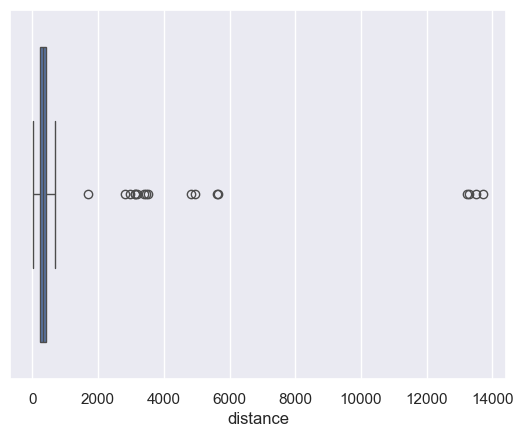

In [118]:
# Detecting Outliers
sns.boxplot(x=fsq_data['distance'])
plt.show()

There are outliers in the mean of distance variable. This will be kept as is and evaluated again after data joining.

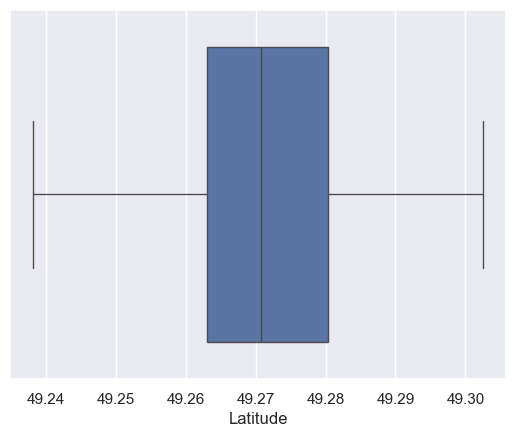

In [133]:
sns.boxplot(x=city_bikes_data['Latitude'])
plt.show()

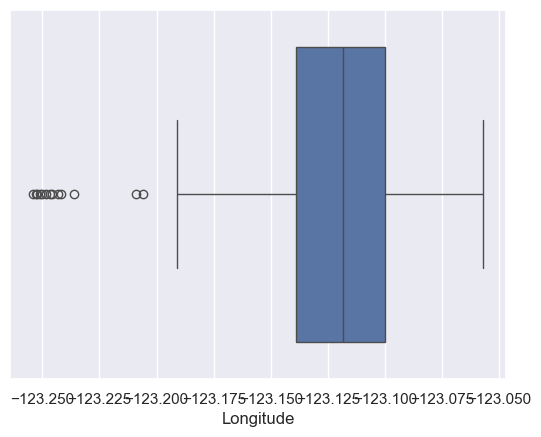

In [131]:
sns.boxplot(x=city_bikes_data['Longitude'])
plt.show()

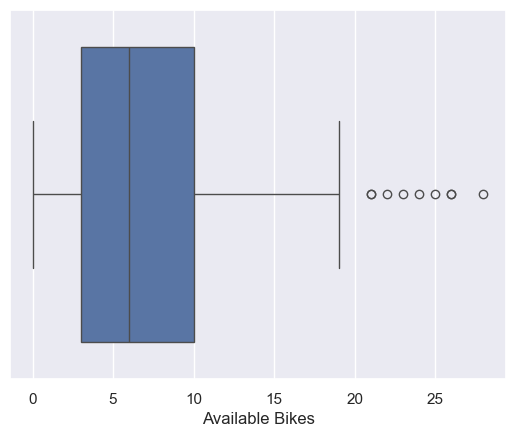

In [141]:
# box plot for free bikes
sns.boxplot(x=city_bikes_data['Available Bikes'])
plt.show()

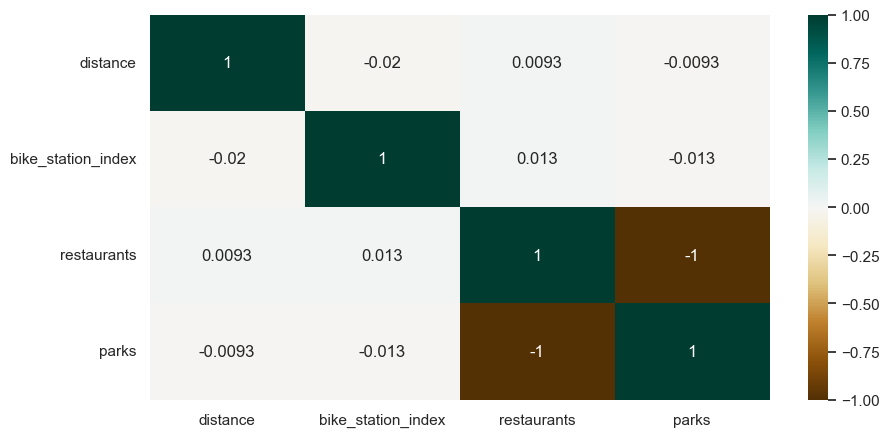

In [121]:
# Heat Maps
plt.figure(figsize=(10,5))
c= fsq_data.corr(numeric_only=True)
sns.heatmap(c,cmap="BrBG",annot=True)
c
plt.show()

<Figure size 1000x500 with 0 Axes>

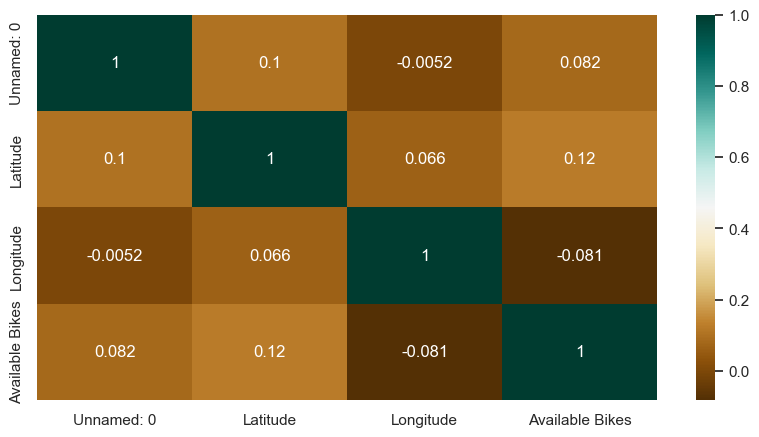

In [143]:
# Heat Maps
plt.figure(figsize=(10,5))
c= city_bikes_data.corr(numeric_only=True)
sns.heatmap(c,cmap="BrBG",annot=True)
c
plt.show()

The heat maps above shows low correlation between the variables (features)

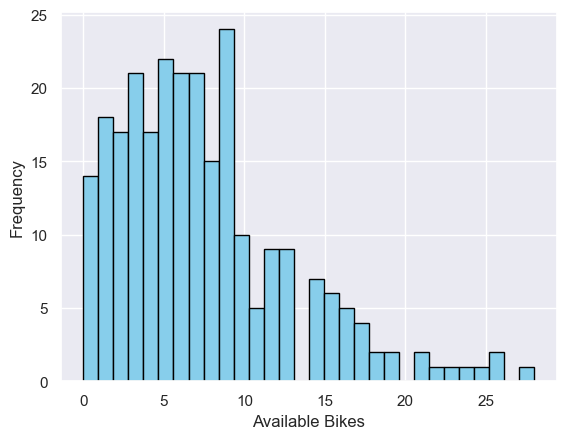

In [149]:
# Plot different features against one another (scatter), against frequency (histogram)
# Histogram

# Plotting a basic histogram
plt.hist(city_bikes_data['Available Bikes'], bins=30, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Available Bikes')
plt.ylabel('Frequency')
 
# Display the plot
plt.show()

The scatter plot will be provided in the joining he data section after joining the data.

In [119]:
# Save the clean data to a csv file
fsq_data.to_csv('fsq_data_cleaned.csv')


In [125]:
city_bikes_data.to_csv('city_bikes_cleaned.csv')